In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.linalg import toeplitz
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

In [26]:
#Data

asset_ticker = "AAPL"
market_ticker = "^GSPC"
risk_free_ticker = "^IRX"

start_date = "2020-01-01"
end_date = "2024-01-01"

In [27]:
#Returns

warnings.filterwarnings("ignore")
asset_data = yf.download(asset_ticker, start=start_date, end=end_date, progress=False)["Close"]
market_data = yf.download(market_ticker, start=start_date, end=end_date, progress=False)["Close"]
rf_data = yf.download(risk_free_ticker, start=start_date, end=end_date, progress=False)["Close"]

asset_returns = asset_data.pct_change().dropna()
market_returns = market_data.pct_change().dropna()

rf_returns = rf_data.shift(1).fillna(method="ffill") / 100  
rf_returns = rf_returns.reindex(asset_returns.index).fillna(method="ffill")

asset_returns = asset_returns.squeeze()
market_returns = market_returns.squeeze() 
rf_returns = rf_returns.squeeze()  
excess_asset_returns = asset_returns - rf_returns
excess_market_returns = market_returns - rf_returns


In [28]:
X = sm.add_constant(excess_market_returns)
y = excess_asset_returns  
X.columns = ["Constant", "Excess Market Returns"]

capm_model = sm.OLS(y, X).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     4968.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:51:40   Log-Likelihood:                 2985.5
No. Observations:                1005   AIC:                            -5967.
Df Residuals:                    1003   BIC:                            -5957.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Constant                  0.00

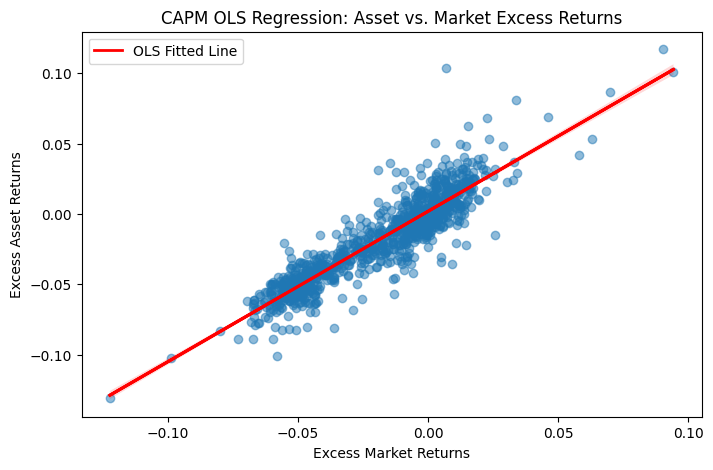

In [29]:
fitted_values = capm_model.fittedvalues

plt.figure(figsize=(8, 5))
sns.regplot(x=excess_market_returns, y=excess_asset_returns, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})

plt.plot(excess_market_returns, fitted_values, color="red", linewidth=2, label="OLS Fitted Line")
plt.xlabel("Excess Market Returns")
plt.ylabel("Excess Asset Returns")
plt.title("CAPM OLS Regression: Asset vs. Market Excess Returns")

plt.legend()
plt.show()

In [ ]:
#Estimation of the covariance matrix Sigma

residuals = pd.Series(capm_model.resid)

def find_best_arima(data, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    for order in product(p_range, d_range, q_range):
        try:
            model = ARIMA(data, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_model = model
        except:
            continue 

    return best_model, best_order

p_range = range(0, 4)
d_range = range(0, 2)
q_range = range(0, 4)

warnings.filterwarnings("ignore", message=".*A date index has been provided.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Non-stationary starting autoregressive parameters.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Non-invertible starting MA parameters found.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*Maximum Likelihood optimization failed to converge.*")

model, best_order = find_best_arima(residuals, p_range, d_range, q_range)

In [ ]:
# Extract parameters
sigma2 = model.scale 
ar_params = model.arparams if model.arparams.size > 0 else np.array([])
ma_params = model.maparams if model.maparams.size > 0 else np.array([])

# AR and MA polynomials
ar_poly = np.r_[1, -ar_params] if ar_params.size else np.array([1])
ma_poly = np.r_[1, ma_params] if ma_params.size else np.array([1])

# Manual autocovariance computation
def compute_acovf(ar, ma, sigma2, lags):
    acovf = np.zeros(lags)
    acovf[0] = sigma2 * (1 + np.sum(ma**2)) / (1 - np.sum(ar**2)) if np.sum(ar**2) < 1 else sigma2

    for lag in range(1, lags):
       
        ar_slice = ar[:min(lag, len(ar))]
        acovf_slice = acovf[:lag][::-1]

        
        if len(ar_slice) != len(acovf_slice):
            diff = abs(len(ar_slice) - len(acovf_slice))
            if len(ar_slice) < len(acovf_slice):
                ar_slice = np.pad(ar_slice, (0, diff))
            else:
                acovf_slice = np.pad(acovf_slice, (0, diff))

        acovf[lag] = np.dot(ar_slice, acovf_slice)

    return acovf


acovf = compute_acovf(ar_params, ma_params, sigma2, len(residuals))


cov_matrix = toeplitz(acovf)

print("Covariance matrix shape:", cov_matrix.shape)
print(np.min(np.linalg.eigvalsh(cov_matrix)))


Covariance matrix shape: (1005, 1005)
0.7531034430234995


In [ ]:
#GLS

capm_gls = sm.GLS(y, X, sigma=cov_matrix).fit()
print(capm_gls.summary())

                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.836
Model:                            GLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     5099.
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:38:27   Log-Likelihood:                 2990.5
No. Observations:                1005   AIC:                            -5977.
Df Residuals:                    1003   BIC:                            -5967.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Constant                  0.00

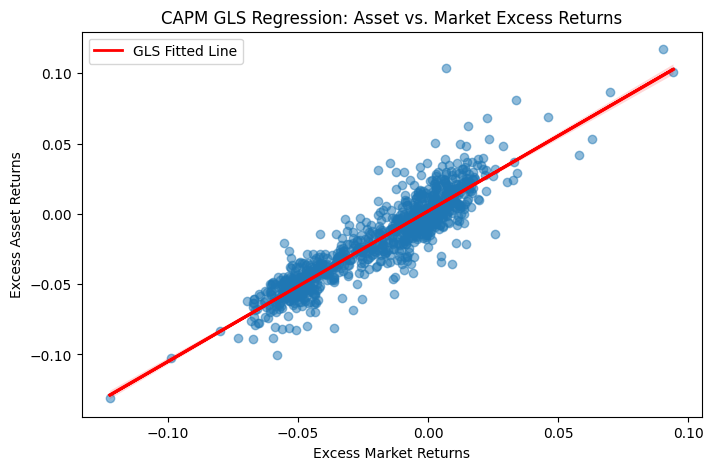

In [ ]:
fitted_values = capm_gls.fittedvalues

plt.figure(figsize=(8, 5))
sns.regplot(x=excess_market_returns, y=excess_asset_returns, scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})

plt.plot(excess_market_returns, fitted_values, color="red", linewidth=2, label="GLS Fitted Line")
plt.xlabel("Excess Market Returns")
plt.ylabel("Excess Asset Returns")
plt.title("CAPM GLS Regression: Asset vs. Market Excess Returns")

plt.legend()
plt.show()